In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [2]:
class Activation:
    def __init__(self):
        pass

    def __call__(self, x):
        return self._function(x)

    def _function(self, x):
        return 0.

    def calc_gradients(self, x):
        return 0.

class LossFunction:
    def __init__(self):
        pass

    def __call__(self, y, t):
        return self._function(y, t)

    def _function(self, y, t):
        return 0.

    def calc_gradients(self, y, t):
        return 0.

In [8]:
class Softmax(Activation):
    def __init__(self):
        super(Softmax, self).__init__()

    def _function(self, x):
        exps = np.exp(x - np.max(x, 1, keepdims=True))
        f = exps / np.sum(exps, 1, keepdims=True)

        return f

    def calc_gradients(self, x):
        # can be more simpler....
        # diag(i=j): f_i * (1 - f_j)
        # non-diag(i!=j): -f_i*f_j
        f = self(x)
        g = np.zeros((x.shape[0], x.shape[1], x.shape[1]))
        diag = np.multiply(f, 1. - f)

        for i in range(x.shape[1]):
            g[:, i, i] = diag[:, i]
        for i in range(x.shape[1]):
            for j in range(x.shape[1]):
                if i == j: continue
                g[:, i, j] = - np.multiply(f[:, i], f[:, j])
        return g

class Sigmoid(Activation):
    def __init__(self):
        super(Sigmoid, self).__init__()

    def _function(self, x):
        return 1 / (1 + np.exp(-x))

    def calc_gradients(self, x):
        f = self._function(x)
        return f * (1 - f)

class Relu(Activation):
    def __init__(self):
        super(Activation, self).__init__()

    def _function(self, x):
        return np.where(0. < x, x, 0.)

    def calc_gradients(self, x):
        f = self(x)
        return np.where(0. < f, 1., 0.)

class Tanh(Activation):
    def __init__(self):
        super(Tanh, self).__init__()

    def _function(self, x):
        return np.tanh(x)

    def calc_gradients(self, x):
        f = self._function(x)
        return 1 - f**2

class Identity(Activation):
    def __init__(self):
        super(Identity, self).__init__()

    def _function(self, x):
        return x

    def calc_gradients(self, x):
        return np.ones_like(x)

############################################################# loss functions
class CrossEntropy(LossFunction):
    def __init__(self):
        super(CrossEntropy, self).__init__()

    def _function(self, y, t):
        y = y + 1e-24
        f = -np.sum(np.multiply(t, np.log(y)), 1)

        return f

    def calc_gradients(self, y, t):
        return -np.multiply(t, 1. / y)

class MeanSquaredError(LossFunction):
    def __init__(self):
        super(MeanSquaredError, self).__init__()

    def __call__(self, y, t):
        return self._function(y, t)

    def _function(self, y, t):
        return np.mean((y - t)**2)

    def calc_gradients(self, y, t):
        return 2 * (y - t) / y.shape[0]

    ############################################################# Optimizer
class GradientDescentOptimizer:
    def __init__(self, lr):
        self.lr = lr

    def set_lr(self, lr):
        self.lr = lr

    def apply_gradients(self, layer):
        for i in range(len(layer.trainable_variables)):
            layer.trainable_variables[i] = layer.trainable_variables[i] - self.lr * layer.gradients[i]
        layer.gradients = None

In [9]:
class DenseLayer:
    def __init__(self, n_in, n_out, activation=None, name=None):
        self.n_in = n_in
        self.n_out = n_out
        self.activation = activation()
        self.name = name
        self.trainable_variables = None
        self.gradients = None

        self._build()
    def _build(self):
        # Xavier initializer
        self.trainable_variables = [
            np.random.normal(scale=np.sqrt(2. / (self.n_in + self.n_out)), size=(self.n_in, self.n_out)),
            np.zeros((1, self.n_out))
        ]

    def __call__(self, x, do_act=True):
        self.x = x
        self.a = np.matmul(self.x, self.trainable_variables[0]) + self.trainable_variables[1]
        if do_act:
            return self.activation(self.a)
        else:
            return self.a

    def calc_gradients(self, g_upper):
        # (delta * W x d_act) * d_theta
        g_act = self.activation.calc_gradients(self.a)

        if isinstance(self.activation, Softmax):
            delta = np.einsum('bnm,bm->bn', g_act, g_upper)
            self.g_w = np.matmul(self.x.T, delta)
            self.g_b = np.sum(delta, 0, keepdims=True)
            self.gradients = [self.g_w, self.g_b]
            # g_upper = np.expand_dims(g_upper, 1)
            # delta = np.multiply(g_upper, g_act)
            # delta = np.sum(delta, 2)
            # self.g_w = np.matmul(self.x.T, delta)
            # self.g_b = np.sum(delta, 0, keepdims=True)
            # self.gradients = [self.g_w, self.g_b]
        else:
            delta = np.multiply(g_upper, g_act)
            self.g_W = np.matmul(self.x.T, delta)
            self.g_b = np.sum(delta, 0, keepdims=True)
            self.gradients = [self.g_W, self.g_b]

        return np.matmul(delta, self.trainable_variables[0].T)

In [10]:
class MLP:
    def __init__(self, loss_func, learning_rate):
        self.loss_func = loss_func()
        self.opt = GradientDescentOptimizer(learning_rate)
        self._build()

    def _build(self):
        self.layers = [
            DenseLayer(64, 128, Relu, name='layer 1'),
            DenseLayer(128, 128, Relu, name='layer 2'),
            DenseLayer(128, 10, Softmax, name='layer 3')
        ]

    def fit(self, x, t):
        y = self(x)
        loss = self.loss_func(y, t)

        # backpropagation of error
        g = self.loss_func.calc_gradients(y, t)
        for l in self.layers[::-1]:
            g = l.calc_gradients(g)

        # applying the gradients
        for l in self.layers:
            self.opt.apply_gradients(l)

        return np.mean(loss)

    def __call__(self, x):
        z = x
        for l in self.layers:
            z = l(z)

        return z

    def accuracy(self, x, t):
        y = self(x)
        acc = np.mean(np.equal(np.argmax(y, 1), np.argmax(t, 1)).astype(np.float32))
        return acc


In [11]:
def scale(X):
    min_val = np.min(X)
    max_val = np.max(X)
    return (X - min_val) / (max_val - min_val)

def onehot_encode(t):
    n_classes = len(np.unique(t))
    return np.eye(n_classes)[t]

def split(X, t):
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X = X[idx]
    t = t[idx]

    te_size = len(X) // 4
    te_X, te_t = X[:te_size], t[:te_size]
    val_X, val_t = X[te_size:te_size*2], t[te_size:te_size*2]
    tr_X, tr_t = X[te_size*2:], t[te_size*2:]

    return tr_X, tr_t, val_X, val_t, te_X, te_t

- epoch: 0, step: 0, loss: 2.443141, tr acc: 0.187500, val acc: 0.120267
- epoch: 0, step: 10, loss: 2.512148, tr acc: 0.343750, val acc: 0.218263
* end of epoch(0), test acc: 0.530067

- epoch: 1, step: 0, loss: 1.468452, tr acc: 0.625000, val acc: 0.628062
- epoch: 1, step: 10, loss: 0.711553, tr acc: 0.859375, val acc: 0.815145
* end of epoch(1), test acc: 0.841871

- epoch: 2, step: 0, loss: 0.698537, tr acc: 0.843750, val acc: 0.844098
- epoch: 2, step: 10, loss: 0.470754, tr acc: 0.937500, val acc: 0.884187
* end of epoch(2), test acc: 0.899777

- epoch: 3, step: 0, loss: 0.535794, tr acc: 0.906250, val acc: 0.888641
- epoch: 3, step: 10, loss: 0.390474, tr acc: 0.937500, val acc: 0.897550
* end of epoch(3), test acc: 0.928730

- epoch: 4, step: 0, loss: 0.470670, tr acc: 0.921875, val acc: 0.902004
- epoch: 4, step: 10, loss: 0.358843, tr acc: 0.937500, val acc: 0.915367
* end of epoch(4), test acc: 0.926503

- epoch: 5, step: 0, loss: 0.442757, tr acc: 0.921875, val acc: 0.9153

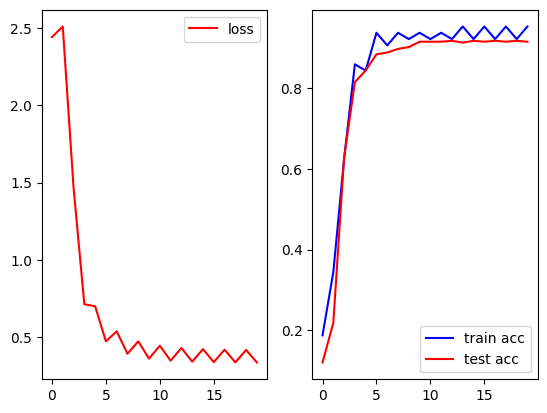

In [12]:
data = load_digits()
X, t = data.images, data.target
X = X.reshape((len(X), -1))
X = scale(X)
t = onehot_encode(t)
tr_X, tr_t, val_X, val_t, te_X, te_t = split(X, t)

# X, t = fetch_california_housing(return_X_y=True, as_frame=False)
# tr_X, tr_t, val_X, val_t, te_X, te_t = split(X, t)

learning_rate = 1e-2
# mlp = MLP(loss_func=MeanSquaredError, learning_rate=learning_rate)
mlp = MLP(loss_func=CrossEntropy, learning_rate=learning_rate)

losses, tr_accs, val_accs = [], [], []
n_batch = 64
n_epoch = 10
for e in range(n_epoch):
    for i in range(int(np.ceil(len(tr_X) / n_batch))):
        mb_X, mb_t = tr_X[i*n_batch:(i+1)*n_batch], tr_t[i*n_batch:(i+1)*n_batch]
        loss = mlp.fit(mb_X, mb_t)

        if i % 10 == 0:
            tr_acc = mlp.accuracy(mb_X, mb_t)
            val_acc = mlp.accuracy(val_X, val_t)

            losses.append(loss)
            tr_accs.append(tr_acc)
            val_accs.append(val_acc)

            print('- epoch: %d, step: %d, loss: %f, tr acc: %f, val acc: %f' % (e, i, loss, tr_acc, val_acc))
            # print('- epoch: %d, step: %d, loss: %f' % (e, i, loss))

    learning_rate = learning_rate * 0.5
    mlp.opt.set_lr(learning_rate)

    te_acc = mlp.accuracy(te_X, te_t)
    print('* end of epoch(%d), test acc: %f' % (e, te_acc))
    print()

fig, ax = plt.subplots(1, 2)
ax[0].plot(losses, label='loss', c='r')
ax[1].plot(tr_accs, label='train acc', c='b')
ax[1].plot(val_accs, label='test acc', c='r')
ax[0].legend()
ax[1].legend()
fig.show()

In [ ]:
import torch